# Prototype Selection

In this notebook I used an unsupervised learning technique called prototype selection to improve the performance of a model trained on a small subsection of available data. The idea is to select a subset of the data that is representative of the entire dataset, and then train a model on this subset rather than a random subset. To accomplish this, I used kmeans to create an amount of clusters that matches the number of examples specified for the subset of the data. For each cluster, the example which falls closest to each centroid (which is the center of each cluster found by kmeans) is selected for use in the subset. The result of this are data points that contain more information about the differences within the dataset as a whole than a random subset would.

Data Exploration and Preprocessing, as well as training our baseline model was done in the notebook Data_Preparation_Model_Baseline.ipynb

Additionally, the data was sourced from here: https://www.kaggle.com/datasets/adityaramachandran27/world-air-quality-index-by-city-and-coordinates

# Initial Model

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import random
import os
from sklearn.cluster import KMeans

Here we load in the preprocessed data.

In [2]:
X = np.load('processed_AQI.npy')
y = np.load('processed_latlng.npy')

print(X.shape)
print(y.shape)

(16393, 14)
(16393, 2)


Here we split our data.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (13114, 14)
X_test shape:  (3279, 14)
y_train shape:  (13114, 2)
y_test shape:  (3279, 2)


This Random Forest clf contains the best parameters from our inital testing done in  Data_Preparation_Model_Baseline.ipynb 

It recieves a MSE of 1.2982

In [4]:
clf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=2, random_state=42)
clf.fit(X_train, y_train)

#mse
y_pred = clf.predict(X_test)
print("The mean squared error (MSE) on test set: {:.4f}".format(mean_squared_error(y_test, y_pred)))

The mean squared error (MSE) on test set: 1.2982


The plot below are predicted values for the latitude and longitude of the test set. The red dots are the pred values. The green dots are the actual values. This model, which is trained on all the data, does a good job of predicting the latitude and longitude of the test set.

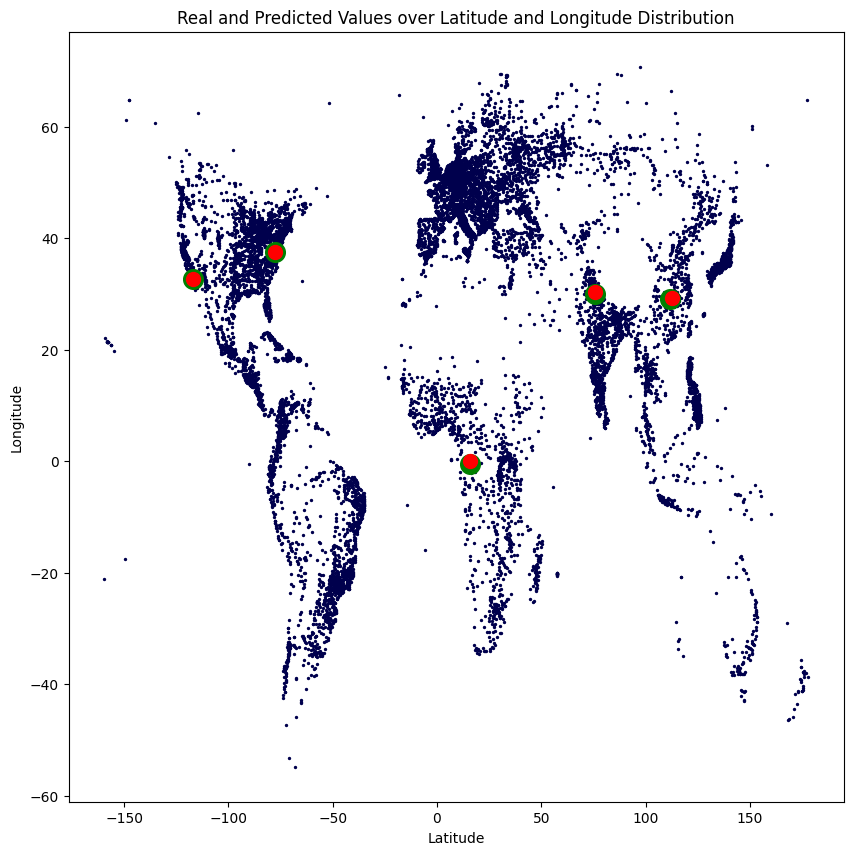

In [6]:
def plot_preds():
    #make and store predictions
    predictions = clf.predict(X_test)
    saved_preds = []
    saved_actual = []
    for i in range(5):
        num = random.randint(0, len(X_test))
        saved_actual.append(y_test[num])
        saved_preds.append(predictions[num])

    #create a scatterplot of the lattitue and longitude of each datapoint
    light_blue = np.array([0, 0, 1]) * 0.3
    plt.figure(figsize=(10, 10))
    plt.scatter(y[:, 1], y[:, 0], color=light_blue, s=2)

    #plot real and predicted values over the lat and lng distribution
    for i in range(len(saved_actual)):
        plt.scatter(saved_actual[i][1], saved_actual[i][0], c='g', marker = 'o', s=200)
        plt.scatter(saved_preds[i][1], saved_preds[i][0], c='r', marker = 'o', s=100)

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Real and Predicted Values over Latitude and Longitude Distribution')

    plt.show()

plot_preds()

# Training Model on Data Subset

Now that we can see how well the model performs on the entire dataset, let's remove 95% of the data and see how well it performs.

In [7]:
subset_X = X[:int(len(X)/20)] #
subset_y = y[:int(len(y)/20)]

print(f'one_p_X shape: {subset_X.shape}')
print(f'one_p_y shape: {subset_y.shape}\n')

X_train, X_test, y_train, y_test = train_test_split(subset_X, subset_y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

one_p_X shape: (819, 14)
one_p_y shape: (819, 2)

X_train shape:  (655, 14)
X_test shape:  (164, 14)
y_train shape:  (655, 2)
y_test shape:  (164, 2)


MSE has increased nearly 10 fold. From 1.2982 to 11.8052. This gives us a good starting point for improving this model with unsupervised learning techniques.

In [9]:
clf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=2, random_state=42)
clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)
print("The mean squared error (MSE) on test set: {:.4f}".format(mean_squared_error(y_test, y_pred)))

The mean squared error (MSE) on test set: 11.8052


We can also see that, although still relatively close, predictions and actual are further from each other than when trained on the entire set.

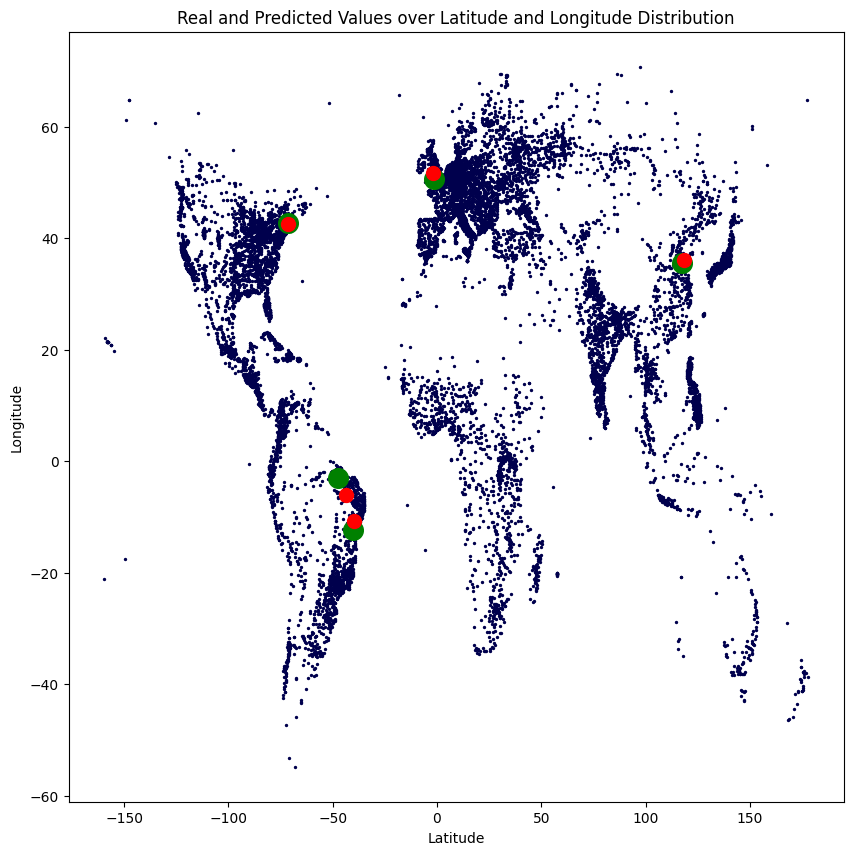

In [10]:
plot_preds()

# Selecting Representative Examples with KMeans

To improve performance while still using 5% of the data, we'll find the optimal 5% of the data. This will be done with KMeans.

5% of the data means 819 examples. We will cluster the entire set into 163 clusters. Then, we will use the closest examples to the centroid of each cluster as our 819 examples to train on. This ensures those the 819 examples we use preserve the most variance in the data.

In [12]:
import numpy as np
from sklearn.cluster import KMeans

k = 819
kmeans = KMeans(n_clusters=k)
clustered = kmeans.fit_transform(X)


best_X_idx = np.argmin(clustered, axis=0) #get indicies of best examples
best_X, best_y = X[best_X_idx], y[best_X_idx] #get best examples and their targets
print(f'Best_X shape: {best_X.shape}'), print(f'Best_y shape: {best_y.shape}')

C:\Users\hunte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best_X shape: (819, 14)
Best_y shape: (819, 2)


(None, None)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(best_X, best_y, test_size=0.2, random_state=42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (655, 14)
X_test shape:  (164, 14)
y_train shape:  (655, 2)
y_test shape:  (164, 2)


Now, lets train our clf on the new data and see how it performs.    

In [14]:
clf = RandomForestRegressor(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=2, random_state=42)

# Train the classifier
clf.fit(best_X, best_y)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Print the mse
print("The mean squared error (MSE) on test set: {:.4f}".format(mean_squared_error(y_test, y_pred)))

The mean squared error (MSE) on test set: 5.8326


By selecting the most representative samples, we were able to reduce the MSE by a factor of 2.024 while using the same 5% subset fo the original dataset.